# Analysis of model for repelling-then-attracting particle model
- TODO: move this to bgmc

the deterministic model is 

$$
\frac{d\bar R}{dt} = -\frac{2a}{\bar R}\cos(\omega t).
$$

integrating, we find

\begin{aligned}
\text{MSR}(t_f-t) = 4a\frac{\sin(\omega (t_f-t))}{\omega}
\end{aligned}

in the short-time limit, we find 

$$
\text{MSR}(t_f-t) \sim 4a (t_f-t) \text{ as } (t_f-t)\rightarrow 0
$$


In choosing, the lifetime, $\Gamma=t_f-t_0$, we also choose the mean value for the apparent attraction coefficient, according to

$$
\hat a=??(\Gamma)
$$

^this is hard to compute analytically, so let's simulate it 1000 times in numpy...

The stochastic model is

$$
d\bar R = -\frac{2a}{\bar R}\cos(\omega t)dt + \sqrt{4D}dW
$$

not 


$$
d\bar R = -\frac{2a}{\bar R}\cos(\omega t)dt + \sqrt{2D}dW
$$

# Analysis of model for repelling-then-attracting particle model
- TODO: move this to bgmc

the deterministic model is 

$$
\frac{d\bar R}{dt} = -\frac{2a}{\bar R}\cos(\omega t).
$$

integrating, we find

\begin{aligned}
\text{MSR}(t_f-t) = 4a\frac{\sin(\omega (t_f-t))}{\omega}
\end{aligned}

in the short-time limit, we find 

$$
\text{MSR}(t_f-t) \sim 4a (t_f-t) \text{ as } (t_f-t)\rightarrow 0
$$


In choosing, the lifetime, $\Gamma=t_f-t_0$, we also choose the mean value for the apparent attraction coefficient, according to

$$
\hat a=??(\Gamma)
$$

^this is hard to compute analytically, so let's simulate it 1000 times in numpy...

# GOAL: simulate $\hat a=??(\Gamma)$ using the monte-carlo method

In [1]:
#TODO: copy old simulation from bgmc


In [2]:
#TODO: modify ^this old simulation to releast and have an effective force in the sinusoidal model

In [3]:
import cupy as cp, numpy as np
import time
import matplotlib.pyplot as plt
from lib import *
from scipy.signal import savgol_filter
import dask.bag as db

In [4]:
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel

In [5]:
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [6]:
seed=42
# #random number stream A
# rs = RandomState(MT19937(SeedSequence(seed)))
# #random number stream B
# # rs = RandomState(MT19937(SeedSequence(987654321)))
np.random.seed(seed)
# cp.random.seed(seed)

# define module  - TODO: port module to lib

In [7]:
# num_pairs=150 #number of independent pairs of particles
# a=8.5 #cm^2/s known attraction coefficient 
# D=0.3 #cm^2/s known diffusion coefficient
# Dt=1e-5 #s
# initial_phase_orientation=np.pi#0.#radians
# period_of_oscillation=90.#ms
# rstart=0.11
# rend=0.1 #cm
# printing=False
# print_every=10000
# mode='oscillatory'
# use_early_stopping=True
# # **kwargs

In [8]:
def gener_positions_oscillatory(
    num_pairs=150, #number of independent pairs of particles
    a=8.5, #cm^2/s known attraction coefficient 
    D=0.3, #cm^2/s known diffusion coefficient
    Dt=1e-5, #s
    initial_phase_orientation=0.,#radians
    period_of_oscillation=90.,#ms
    rstart=0.2,
    rend=0.1, #cm
    printing=False,print_every=50000,
    mode='oscillatory',
    use_early_stopping=True,
    **kwargs
    ):
    '''
    Example Usage:
    dict_out,positions_out=gener_positions_oscillatory(a=a,D=D,printing=True)
    '''
    dont_break=True
    #initialize particles locations as being at the same locations
    t=0
    x1=0
    x2=np.sqrt(rstart)
    y1=0
    y2=np.sqrt(rstart)
    zero_values=np.zeros(num_pairs)

    x1_values=zero_values.copy()+x1
    x2_values=zero_values.copy()+x2
    y1_values=zero_values.copy()+y1
    y2_values=zero_values.copy()+y2

    stepscale = np.sqrt(2 * D * Dt)  #stepsize for each coordinate x,y
    impulse_prefactor = a * Dt

    tmax=10#0.1#1 #seconds
    num_steps=np.int64(np.around(tmax/Dt))

    position_array=np.zeros(shape=(num_steps,4,num_pairs))+np.nan
    mean_array=np.zeros(shape=(num_steps,3))
    std_array=np.zeros(shape=(num_steps,3))

    #add support for still_running
    boo_still_running=zero_values==zero_values

    #compute the distance between each pair of particles
    dx_values=(x2_values-x1_values)
    dy_values=(y2_values-y1_values)
    Rsq_values=dx_values*dx_values+dy_values*dy_values
    omega=1/(1e-3*period_of_oscillation/(2*np.pi))
    random_time_constant=initial_phase_orientation*omega
    if printing:
        print(f"running simulation for {num_steps} steps...")
    start=time.time()
    step_num=0
    while dont_break and (step_num < num_steps):
        t=step_num*Dt + random_time_constant
        #compute the attractive step between all pairs
        f_values=impulse_prefactor/Rsq_values
        F1x=f_values*dx_values
        F1y=f_values*dy_values
        if mode=='oscillatory':
            F1x*=np.sin(omega*t)
            F1y*=np.sin(omega*t)

        #compute the diffusive step between all pairs
        dxW1_values=stepscale*np.random.normal(size=num_pairs)
        dxW2_values=stepscale*np.random.normal(size=num_pairs)
        dyW1_values=stepscale*np.random.normal(size=num_pairs)
        dyW2_values=stepscale*np.random.normal(size=num_pairs)

        #the mean distance between all pairs of particles
        R_values=np.sqrt(Rsq_values)
        mean_R=np.mean(R_values)
        std_R=np.std(R_values)

        #the mean magnitude of the diffusive step
        diffusive_step_values=0.5*np.sqrt(dxW1_values**2+dyW1_values**2)+0.5*np.sqrt(dxW2_values**2+dyW2_values**2)
        mean_diffusive_step=np.mean(diffusive_step_values)
        std_diffusive_step=np.std(diffusive_step_values)

        #the mean magnitude of the attractive step
        attractive_step_values=np.sqrt(F1x**2+F1y**2)
        mean_attractive_step=np.mean(attractive_step_values)
        std_attractive_step=np.std(attractive_step_values)
        if printing:
            if (step_num+1) % print_every == 0:
                relative_percent=100*mean_diffusive_step/mean_attractive_step
                print(f"simulation {100*(step_num+1)/num_steps:.0f}% completed: R={mean_R:.4f}+/-{1.96*std_R:.4f}, diffusion/attraction is {relative_percent:.2f}%")
                # print(f"the mean range is {mean_R:.4f} cm")
                # print(f"the mean diffusive step was {100*mean_diffusive_step/mean_attractive_step:.2f}% larger than the mean attractive step")

        #compute the net change in position 
        x1step_values=F1x+dxW1_values
        y1step_values=F1y+dyW1_values
        x2step_values=-F1x+dxW2_values
        y2step_values=-F1y+dyW2_values

        #identify any particles that didn't get within the threshold distance
        #compute the distance between each pair of particles
        dx_values=(x2_values-x1_values)
        dy_values=(y2_values-y1_values)
        Rsq_values=dx_values**2+dy_values**2

        #update particle locations if they are still running
        x1_values[boo_still_running]=x1_values[boo_still_running]+x1step_values[boo_still_running]
        y1_values[boo_still_running]=y1_values[boo_still_running]+y1step_values[boo_still_running]
        x2_values[boo_still_running]=x2_values[boo_still_running]+x2step_values[boo_still_running]
        y2_values[boo_still_running]=y2_values[boo_still_running]+y2step_values[boo_still_running]
        #DONE: verified the mean distance between particles got smaller    
        # if (step_count+1) % save_every == 0:
        #save particle locations to a numpy array with the correct number of positions
        # x1,y1,x2,y2
        position_array[step_num,0,boo_still_running]=x1_values[boo_still_running]
        position_array[step_num,1,boo_still_running]=y1_values[boo_still_running]
        position_array[step_num,2,boo_still_running]=x2_values[boo_still_running]
        position_array[step_num,3,boo_still_running]=y2_values[boo_still_running]
        mean_array[step_num,0]=mean_R
        mean_array[step_num,1]=mean_diffusive_step
        mean_array[step_num,2]=mean_attractive_step
        #save results for quick plotting
        std_array[step_num,0]=std_R
        std_array[step_num,1]=std_diffusive_step
        std_array[step_num,2]=std_attractive_step

    #         #identify any particles that didn't get within the threshold distance
    #         #compute the distance between each pair of particles
    #         dx_values=(x2_values-x1_values)
    #         dy_values=(y2_values-y1_values)
    #         Rsq_values=dx_values*dx_values+dy_values*dy_values
        R_values=np.sqrt(Rsq_values)
        boo_still_running=boo_still_running&(R_values>rend)
        
        step_num+=1
        if use_early_stopping and not boo_still_running.any():
            dont_break=False
    if printing:
        print(f"simulation complete!\nTotal run time: {time.time()-start:.4f} seconds")
        print(f"the number of particles that didn't finished is {sum(boo_still_running)} out of {boo_still_running.shape[0]}.")

    #DONE/DONT(ignore): compute the apparent attraction coefficient without smoothing
    # np.argwhere(np.isnan(position_array[:,0,i])).flatten()
    #identify any pairs that didn't end up closer than rend
    boo_didnt_finish=~np.isnan(position_array[-1,0,:])
    pairs_didnt_finish=np.argwhere(boo_didnt_finish).flatten()
    #     if printing:
    #         print((boo_didnt_finish.shape,pairs_didnt_finish))
    set_pairs_ignore=set(pairs_didnt_finish)

    tmax_recall=0.1 #max time to recall before the value is not nan
    num_rows_recall=np.int64(np.around(tmax_recall/Dt))
    if printing:
        print(f"num_rows_recall={num_rows_recall}")

    #for each pair, identify the last row where the value is not nan
    row_end_values=zero_values.copy()+np.nan
    for i in range(num_pairs):
        if not set_pairs_ignore.issuperset({i}):
            #record end values for lifetimes
            row_end=np.int64(np.argwhere(np.isnan(position_array[:,0,i]))[0,0])-1
            row_end_values[i]=row_end

            #this step can introduce some error
            if row_end<num_rows_recall:
                #add this i to the ignore list
                set_pairs_ignore.add(i)

    #DONE: add pair to set_pairs_ignore if it ends sooner than num_rows_recall

    #for each pair not to be ignored, put the last num_rows_recall before row_end_values into an array
    positions_lst=[]
    for i in range(num_pairs):
        if not set_pairs_ignore.issuperset({i}):
            row_end=np.int64(row_end_values[i])
            if row_end>=num_rows_recall:
                positions=position_array[row_end-num_rows_recall:row_end,:,i]
            else:
                num_rows_rec=row_end
                num_rows_pad=num_rows_recall-row_end
                #pad the start with nans
                nan_pad=np.full([num_rows_pad,4], np.nan)
                positions=position_array[row_end-num_rows_rec:row_end,:,i]
                #pad positions at its front
                positions=np.concatenate((nan_pad,positions))

            positions_lst.append(positions)
    positions_out=np.stack(positions_lst,axis=-1)
    #     del position_array
    #     del positions_lst

    #record lifetime of last remaining particle
    Gamma_max=step_num*Dt
    Gamma_values=row_end_values*Dt
    dict_out={
        "Gamma_max":np.float32(Gamma_max),
        "Gamma_values":Gamma_values.astype('float32'),
        "Rsq_values":Rsq_values.astype('float32'),
        "mean_array":mean_array.astype('float32'),
        "std_array":std_array.astype('float32')
    }
    if printing:
        print(*dict_out)
        #print_dict(dict_out)
    return dict_out,positions_out

In [9]:
# # # position_array[row_end-num_rows_recall:row_end,:,i]
# # # num_rows_recall,row_end,i
# # # positions_lst[0]
# # positions
# # num_rows_pad
# Gamma_values.astype('float32')
# np.float32(0.123)

In [10]:
# # positions_out.all()
# # positions
# Dt

In [11]:
# #debug
# # susa=x1_values
# susa=position_array
# np.isnan(susa).all(),np.isnan(susa).any(),susa.shape
# # x1_values
# # num_steps,step_num

In [12]:
# #     mean_array[step_num,0]=mean_R
# #     mean_array[step_num,1]=mean_diffusive_step
# #     mean_array[step_num,2]=mean_attractive_step
# mean_array.shape
# # Gamma_max=0.06318
# row_end>=num_rows_recall

# analyse the MSR for the oscillatory particle model 

In [13]:
#estimated run time: 11 minutes
testing=True
if testing:
    #2 min. runtime
#     a=8.5
#     D=0.3
    a=1.6
    D=0.6
    num_pairs=100#2min 22sec: 100#1min 30sec: 10+1
    initial_phase_orientation=-np.pi/2
    #initial_phase_orientation=np.pi/2
    # initial_phase_orientation=0.
    # initial_phase_orientation=np.pi
    rstart=0.2#1.5
    #before, long runtime
    dict_out,positions_out = gener_positions_oscillatory(
                a=a, D=D, printing=False,num_pairs=num_pairs,rstart=rstart,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)
    

Gamma_max Gamma_values Rsq_values mean_array std_array
positions_out.shape=(10000, 4, 39)


In [14]:
beep(1)



0

positions_out.shape=(10000, 4, 39)


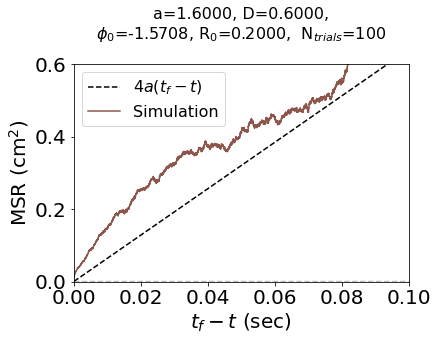

In [15]:
# positions_out=dict_out['positions_out']
Dt=1e-5
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"

print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[::-1,0]
y1_values=positions_out[::-1,1]
x2_values=positions_out[::-1,2]
y2_values=positions_out[::-1,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt
# x_values=aligned_mean_values[:,0]
# plt.plot(aligned_mean_values[:,1])
# plt.plot(aligned_mean_values[:,2])
# plt.plot(aligned_mean_values[:,3])

xmin,xmax=0,0.1
ymin,ymax=0,0.6
xv=np.linspace(xmin,xmax,100)
plt.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(t_values,MSR_values,c='C5',label=r"Simulation")
# plt.plot(t_values,aligned_mean_values[::-1,0]**2)
plt.plot(t_values,t_values*0.,'--',c='gray',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.title(title,fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [16]:
dict_fit=compute_95CI_ols(t_values,MSR_values)
print_dict(dict_fit)
print(f"num_samples={positions_out.shape[-1]}")
print(f"num_timepoints={t_values.shape[0]}")
print(f"ahat = {dict_fit['m']/4:.4f}+/-{dict_fit['Delta_m']/4:.4f}")

m=5.913296630280044
Delta_m=0.02070316138386783
b=0.10589133029887521
Delta_b=0.001195207932113192
Rsquared=0.9690844746880398
num_samples=39
num_timepoints=10000
ahat = 1.4783+/-0.0052


True

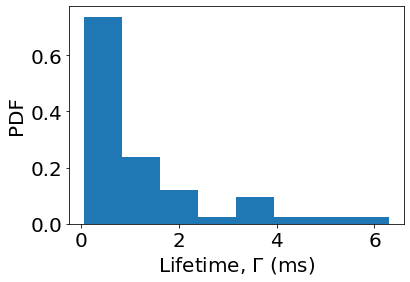

In [17]:
Gamma_values=dict_out['Gamma_values']
xmin,xmax=[0,3.14]
# bins=np.linspace(xmin,xmax,4)
bins='auto'
plt.hist(Gamma_values,density=True,bins=bins)
# plt.xlim([xmin,xmax])
format_plot(ax=plt.gca(),xlabel=r'Lifetime, $\Gamma$ (ms)',ylabel='PDF')

In [18]:
#estimated run time: 11 minutes
testing=True
if testing:
    #2 min. runtime
    a=8.5
    D=0.3
    num_pairs=100#2min 22sec: 100#1min 30sec: 10+1
    initial_phase_orientation=-np.pi/2
    #initial_phase_orientation=np.pi/2
    # initial_phase_orientation=0.
    # initial_phase_orientation=np.pi
    rstart=0.2#1.5
    #before, long runtime
    dict_out,positions_out = gener_positions_oscillatory(
                a=a, D=D, printing=False,num_pairs=num_pairs,rstart=rstart,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)
    

Gamma_max Gamma_values Rsq_values mean_array std_array
positions_out.shape=(10000, 4, 53)


positions_out.shape=(10000, 4, 53)


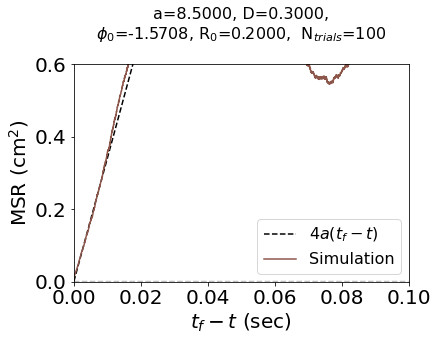

In [19]:
# positions_out=dict_out['positions_out']
Dt=1e-5
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"

print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[::-1,0]
y1_values=positions_out[::-1,1]
x2_values=positions_out[::-1,2]
y2_values=positions_out[::-1,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt
# x_values=aligned_mean_values[:,0]
# plt.plot(aligned_mean_values[:,1])
# plt.plot(aligned_mean_values[:,2])
# plt.plot(aligned_mean_values[:,3])

xmin,xmax=0,0.1
ymin,ymax=0,0.6
xv=np.linspace(xmin,xmax,100)
plt.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(t_values,MSR_values,c='C5',label=r"Simulation")
# plt.plot(t_values,aligned_mean_values[::-1,0]**2)
plt.plot(t_values,t_values*0.,'--',c='gray',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.title(title,fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [20]:
# plt.plot(mean_array[:,2])
# plt.plot(std_array[:,2])

In [21]:
#DONE: check all output for being reasonable


In [22]:
#DONE: check all output for being reasonable
np.isnan(positions_out).all(),np.isnan(positions_out).any(),positions_out.shape

(False, False, (10000, 4, 53))

In [23]:
np.isnan(positions_out).all()

False

what's the runtime on ^this? 

In [24]:
gener_positions_oscillatory

<function __main__.gener_positions_oscillatory(num_pairs=150, a=8.5, D=0.3, Dt=1e-05, initial_phase_orientation=0.0, period_of_oscillation=90.0, rstart=0.2, rend=0.1, printing=False, print_every=50000, mode='oscillatory', use_early_stopping=True, **kwargs)>

# TODO: gridsearch over initial_phase_orientation and initial distance, rstart
- TODO(prereq): get a token basecase working for the default rstart,initial_phase_orientation
- TODO: Visualize Gamma_avg versus rstart for initial_phase_orientation fixed
- TOOD: repeat ^that for a token set of orientations from -np.pi to np.pi

In [25]:
rstart,initial_phase_orientation

(0.2, -1.5707963267948966)

In [26]:
def routine(phi_0):
    try:
        #variable variables are passed as arguments
        initial_phase_orientation=phi_0
        #10 hr runtime per trial
        #fixed variables
        a=8.5
        D=0.3
        rstart=0.2
        num_samples=5e2
        #before, long runtime
        dict_out = gener_positions_oscillatory(
                    a=a, D=D, printing=False,num_pairs=int(num_samples+1),rstart=rstart,initial_phase_orientation=initial_phase_orientation)
        return dict_out
    except Exception as e:
        return None

In [27]:
#TODO: repeat ^this measurement with each of the following:
initial_phase_orientation_values=np.linspace(-np.pi,np.pi,11)
initial_phase_orientation_values

array([-3.14159265, -2.51327412, -1.88495559, -1.25663706, -0.62831853,
        0.        ,  0.62831853,  1.25663706,  1.88495559,  2.51327412,
        3.14159265])

In [28]:
#parallelize with dask.bag
task_lst=list(initial_phase_orientation_values)
#color squared range field in parallelizable fashion
#DONE: dask bag accelerate tshift_tare_routine
printing=True
npartitions=4
# npartitions=None
if npartitions is None:
    npartitions=np.min((os.cpu_count(),len(task_lst)))
    print(f"npartition={npartitions}")
#all CPU version
b = db.from_sequence(task_lst, npartitions=npartitions).map(routine)

#DONE: evaluate task_lst
start = time.time()
retval = list(b)
dict_out_lst=[x for x in retval if x is not None]
if printing:
    print(f"run time simulating oscillatory annihilation events was {time.time()-start:.2f} seconds.")
    print(f"number of successfull trials was {len(dict_out_lst)}")

run time simulating oscillatory annihilation events was 2464.78 seconds.
number of successfull trials was 11


In [29]:
save_folder=f"{nb_dir}/data/oscillatory_results"
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
os.chdir(save_folder)

In [30]:
print(*dict_out_lst[0])

{'Gamma_max': 10.0, 'Gamma_values': array([0.01737, 0.01643, 0.01042,     nan, 0.01459, 0.01711, 0.02006,
       0.01719, 0.01703, 0.02687, 0.01726, 0.01641, 0.01077, 0.0208 ,
       0.01516, 0.02623, 0.01567, 0.01387, 0.01839, 0.01703, 0.01723,
       0.02073, 0.01399, 0.012  , 0.01352, 0.01483, 0.01403, 0.01554,
       0.01229, 0.01847, 0.01681, 0.02203, 0.01576, 0.01395, 0.01583,
       0.01612, 0.02057, 0.01034, 0.01473, 0.01403, 0.01229, 0.01444,
       0.01618, 0.01789, 0.01767, 0.02187, 0.02115, 0.02129, 0.0134 ,
       0.01325, 0.01629, 0.01716, 0.11739, 0.01312, 0.01629, 0.0155 ,
       0.01638, 0.01226, 0.01736, 0.01189, 0.0124 , 0.01538, 0.02213,
       0.01688, 0.01527, 0.01757, 0.01865, 0.01515, 0.01681, 0.01344,
       0.01456, 0.02821, 0.01252, 0.01567, 0.01719, 0.01025, 0.02269,
       0.0158 , 0.0154 , 0.01215, 0.02833, 0.01471, 0.01357, 0.01532,
       0.01171, 0.0166 , 0.01324, 0.01205, 0.01585, 0.01295, 0.01672,
       0.0115 , 0.01823, 0.01655, 0.01317, 0.02163, 0.

In [31]:
positions_out=dict_out_lst[0]['positions_out']
num_pairs=positions_out.shape[-1]

TypeError: tuple indices must be integers or slices, not str

In [ ]:
#DONE: save dict_out_lst as json
# dictout=dict(zip(range(len(dict_out_lst)),dict_out_lst))
# dictout=dict(zip(range( len(dict_out_lst)),dict_out_lst))
save_fn=f'prelim_data_numtrials_{len(dict_out_lst)}_numpairs_{num_pairs}.npz'
np.savez_compressed(save_fn,phi_o=task_lst,**dictout)
# save_fn=f'prelim_data_numtrials_{len(dict_out_lst)}_numpairs_{num_pairs}.json'
# import json
# with open(save_fn, 'w', encoding='utf-8') as f:
#     json.dump(dictout, f, ensure_ascii=False, indent=4)
assert os.path.exists(save_fn)

In [ ]:
# np.savez_compressed?

# TODO: visualize dict_out_lst / MSR vs. tdeath for each dict_out_lst.  label by phi_0.

In [ ]:
phi_0=0
initial_phase_orientation=phi_0
#10 hr runtime per trial
a=8.5
D=0.3
rstart=0.2
num_samples=1
#before, long runtime
dict_out = gener_positions_oscillatory(
            a=a, D=D, printing=False,num_pairs=int(num_samples+1),rstart=rstart,initial_phase_orientation=initial_phase_orientation)

In [ ]:
i